# Notebook to recenter images of a DICOM dataset - CT scan version
Use this notebook to navigate and select a location in the image to recenter a series of images. It loads an specific series and uses the notebook to select a location.

This notebook shows an example how to process a CT dataset. Some tricks need to be done to be sure it can be loaded into the Sonalleve treatment planning. 

**Very important, make as many copies of this notebook for each transformation applied. Like that the notebook is also the documentation of the transformation applied. This will be extremely useful for future analysis or for people reviewing the process**

** Also important. Operations are accumulative, meaning that you have to be careful of applying only once the desired translation/rotation.** If you need to start from scratch, simply re-execute from the cell with the code `A=SelectionMarkersUI(...`

Do not forget to execute cells with "shift-Enter"


In [1]:
%matplotlib nbagg

In [2]:
from __future__ import print_function
from RecenterDicom import *
import matplotlib.pyplot as plt

## Select a directory that contains the DICOMDIR file of the exported dataset
Assign the value to the  ``base_dir`` variable. The code will print a list of all the series. Be sure of having inspected the dataset before with Osirix or any other DICOM viewer so you have an idea already of which dataset to select

In [3]:
base_dir = 'C:\Patient Data\Neuroblastoma\NB2\Patient Data CD2'
PrintDicomDirSeries(base_dir)

Patient: BFEIIEG - 2: BFEIIEG - 2
    Study NOSTUDYID: 20160225: CT Neck/Chest w contrast
        Series 1: SCOUT : CT: SCOUT:  (2 images)
          1.2.528.1.1001.100.3.2037.549.19990825110.20160420210516156
        Series 3: AX LUNG 2.5MM : CT: AX LUNG 2.5MM:  (67 images)
          1.2.528.1.1001.100.3.2037.549.19990825110.20160420210516203
        Series 200: SAG NECK/CHEST C+ : CT: SAG NECK/CHEST C+:  (91 images)
          1.2.528.1.1001.100.3.2037.549.19990825110.20160420210517265
        Series 201: COR NECK/CHEST C+ : CT: COR NECK/CHEST C+:  (84 images)
          1.2.528.1.1001.100.3.2037.549.19990825110.20160420210518703
        Series 202: SAG LUNG MIP : CT: SAG LUNG MIP:  (93 images)
          1.2.528.1.1001.100.3.2037.549.19990825110.20160420210520031
        Series 203: COR LUNG MIP : CT: COR LUNG MIP:  (77 images)
          1.2.528.1.1001.100.3.2037.549.19990825110.20160420210521500
        Series 204: AX LUNG MIP : CT: AX LUNG MIP:  (79 images)
          1.2.528.1.1001.10

## Select a CT scan series by their UID
Just copy the text of the UID above of the series you want to process. This is the best way to be sure you are loading the correct dataset.

## Select a MRI scan series that will be used as template
We'll use an existing MRI dataset to grab any MRI DICOM file as template to do the "conversion" trick (Ari Partanen deserves the credit for this idea).

This function will return only the filenames in the list MRIfiles

Alternative, you could use  a path  to any other MRI dicom file (as much it is single slice) such as:
`PathToMRIFile = "C:\\MyDicomFiles\\OneDataset\\A\\B\\C\\A3424.DCM"` or whatever

#### OPTIONAL: Apply a rotation
Many datasets are not necessarily  showing a patient in the right orientation, especially for furhter analysis with the Sonalleve SW. If the dataset is required to be rotated, **DO IT BEFORE THE RECENTERING!!!!**.
Uncomment and execute the code below if you need a rotation.

For some datasets it rotates correctly, but for some other it rotates in one of other axis. Still need to figure out. But a little try and error for the moment will be still required to rotate the image as needed. Try a combination with axis either being 'RL', 'HF' or 'AP'

In [10]:
A=SelectionMarkersUI(base_dir,'1.2.528.1.1001.100.3.52861.3269.19990825110.20160420214120015')
MRIfiles=ReadSpecificSeries(base_dir,'1.2.528.1.1001.100.3.2037.549.19990825110.20160420212840109',bReturnOnlyFileNames=True)
#uncomment this line to apply a rotation, pick the desired value
A.Rotation(180,axis='HF')

        Series 319: VEO SAG NECK/CHEST C+ : CT: 1.2.528.1.1001.100.3.52861.3269.19990825110.20160420214120015 (104 images)
            Reading images...
        Series 601: COR T2 FS : MR: 1.2.528.1.1001.100.3.2037.549.19990825110.20160420212840109 (28 images)
            Reading images...


## Use the interactive tool to select the number of slice, and (x,y)-coordinates in pixel of the location you want to use as the place to recenter the dataset.
By default the 3D visualization is off to help to select faster the location. Once the location is identified, activating the 3D visualization will help to confim its location in the MRI coordinate system. At this moment, the recenter hasn't yet been applied in the images. 

If already know the location of slice, x-coordinate and y-coordinate (which may the case when reprocessing), you can comment the call to `InteractiveSel()` and un-comment the `ShowData` function call where you specify the # slice and x- and y-coordinates directly. This may be handy to keep documented the changes.

<IPython.core.display.Javascript object>


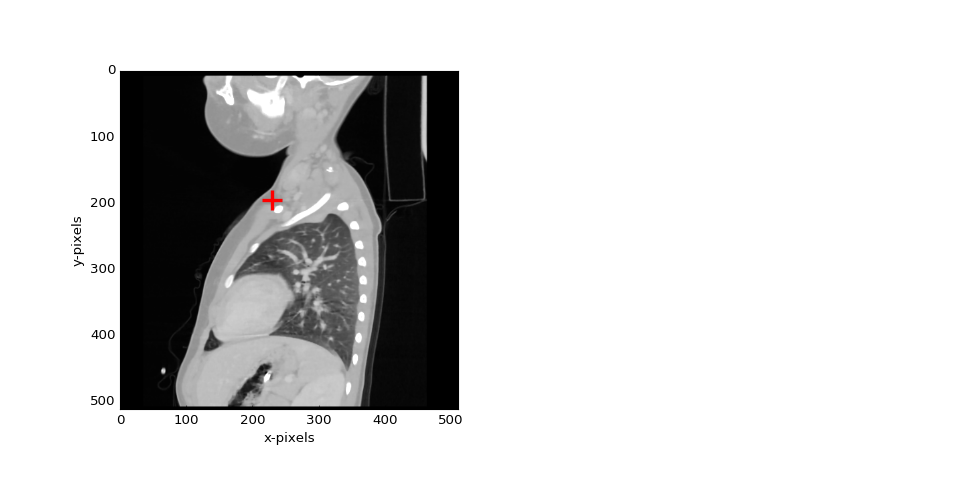

[ 39.89354706   7.60071266 -98.17748207]


In [11]:
A.InteractiveSel()



##  "Execute" the offset to the dataset
The selected location during the navigation is now applied with the code below

In [12]:
A.ApplyOffset()


## "Convert" to MRI DICOM
**Very important**, some CT scans have one or more extra slices at the beginning to show location of the scans. By example:

<img src="./Capture.PNG" width="300" height="300" />

This image needs to be removed from the dataset. To accomplish this, set a value in the parameter **`SkipImages`** in the function `ConvertCTtoMRI`. In this example, we skip only the first image.

You can also notice we just use the first entry of the `MRIfiles` (we just need one). You can replace this by your own path.

### Important notes
As usual when dealing with DICOM files, vendors love to do whatever they want with the standard and sometimes they do not provide all the metadata required to do the "conversion" trick. I have identified 3 fields that may be missing in the GE CT scans: ReconstructionDiameter, SpacingBetweenSlices and SlicePositon. So far, it seems easy to reconstruct them. If any other appears with another dataset, let me know.

### Adjust of contrast
The Sonalleve planning software have some limited control on the adjust of the contrast image. If the CT data is copied natively, a lot of image regions appears hyperintense and cut in intensity. It makes difficult to navigate them.

The parameter `bAdjustContrastParam` activates the adjust of the contrast to make it more readable. It is not 100% as good as a real DICOM viewer but it helps a lot to make it more easy to visualize in the Sonalleve SW. The function `ConvertCTtoMRI` has the following extra parameters controlling the adjustment of contrast. Default values seem to produce reasonable results:
* `lowhighin` (default [0,1]) is a two-value list that  indicates the normalized range of the datatype dynamic to preseve from the input image. [0,1] means that values from 0 to 2^16-1 will be kept. It must have a values from 0 to 1, and lowhighin[1]>lowhighin[0]
*  `lowhighout` (default [0,1]) is a two-value list that   indicates the normalized range of the datatype dynamic to strecth the data. [0,1] means that the input range will be stretched in values ranging from 0 to *2^16-1. 
* `gamma`  (default 1.5) is the exponent coefficient used to adjust background luminosity. Values inferior to 1 increase the luminosity. **This seems to be the best parameter to play around**. Values larger than 1.5 seem to work nicely.

**Very important** If using a `gamma` value greater than 1 the image may look "*completely*" dark on the Sonalleve. The opposite will happen with `gamma` less than 1 (a hyperintense image).  Just adjust the brightness in the Sonalleve and the figure will appear correctly. 

In [13]:
A.ConvertCTtoMRI(MRIfiles[0],SkipImages=1,bAdjustContrastParam=True,gamma=1.6)

Removing the first  1  images ... remember this process is destructive
ReconstructionDiameter ( 0018,1100) no present in DICOMS, we'll reconstruct it using Rows, Columns and PixelSpacing
Non squared FOV = 237.62 237.62  using larger of those...
ReconstructionDiameter 237.62
SpacingBetweenSlices (0018,0088) is not present in DICOMS, we'll reconstruct it using calculating euclidean distance from two ImagePositionPatient entries
SpacingBetweenSlices 2.0


##  Export the data
Specify a directory where to export the data. If the directory does not exist, it will be created. Be sure of avoiding directories with original data. Also, if you call again this step later, all images in the specified subdirectory will be overwritten.

You can specify the flag 'bDeleteFilesFirst=True' to delete files in the target directory. This is useful if you are reusing the same directory over and over. If you end exporting a dataset with less images than a previous exports,it may cause problems in the Sonalleve.

In [14]:
A.ExportData('C:\Patient Data\ExportedForSonnalleve',bDeleteFilesFirst=True)


Please confirm deleting files in C:\Patient Data\ExportedForSonnalleve [n]|y: y


##  Use the data
The exported data is conformal with DICOM viewers and the Sonalleve software. For the Sonalleve, start an standalone operation, input a body temperature. 

Modify the code below to match your Sonalleve directory, the location of dcmtk and the directory where you exported the data. Just run it with shift-Enter as usual and the images should be imported in the Sonalleve. Be sure the last line is correct to put back the current working directory in the notebook.

```
import os
curdir=os.getcwd()
%cd "C:/Program Files (x86)/Philips Medical Systems/HIFU/3.2.740.2311"
%run ./Scripts/DICOM/PlanningImageImporter.py -d "C:\Patient Data\ExportedForSonnalleve" -t "C:\dcmtk-3.6.0-win32-i386\bin"
# DO NOT FORGET TO PUT BACK YOUR CURRENT DIRECTORY
%cd "C:/Users/Charles/Desktop/ReCenterMRI"
```